# Training Loop Example

The notebook contains an example of simple training loop initialization and training.

In [8]:
%matplotlib inline

In [9]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torchvision import models
from torchvision.datasets import MNIST
from torchvision.datasets.folder import pil_loader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop

In [10]:
from tqdm.autonotebook import tqdm
import numpy as np
import pandas as pd

In [11]:
import sys
from pathlib import Path
from functools import partial
try:
    old_path
except NameError:
    old_path = sys.path.copy()
    sys.path = [Path.cwd().parent.as_posix()] + old_path

In [12]:
import re
import math
from collections import ChainMap, OrderedDict, defaultdict

In [13]:
from loop.callbacks import History

In [14]:
def flat_model(model):
    """Converts model with nested modules into single list of modules"""
    
    def flatten(m):
        children = list(m.children())
        if not children:
            return [m]
        return sum([flatten(child) for child in children], [])
    
    return nn.Sequential(*flatten(model))

In [15]:
def as_sequential(model):
    return nn.Sequential(*list(model.children()))

In [16]:
def get_output_shape(model):
    """Pass a dummy input through the sequential model to get the output tensor shape."""
    first, *rest = flat_model(model)
    shape = first.in_channels, 128, 128
    dummy_input = torch.zeros(shape)
    out = model(dummy_input[None])
    return list(out.size())[1:]

In [17]:
class AdaptiveConcatPool2d(nn.Module):
    
    def __init__(self, size=1):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(size)
        self.max = nn.AdaptiveMaxPool2d(size)
        
    def forward(self, x):
        return torch.cat([self.max(x), self.avg(x)], 1)

In [18]:
class Flatten(nn.Module):
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [19]:
def init_default(module, init_fn=nn.init.kaiming_normal_):
    if init_fn is not None:
        if hasattr(module, 'weight'):
            init_fn(module.weight)
        if hasattr(module, 'bias') and hasattr(module.bias, 'data'):
            module.bias.data.fill_(0.)
    return module

In [20]:
def conv2d(ni, no, kernel=3, stride=1, padding=None, bias=False):
    padding = padding or kernel//2
    layer = nn.Conv2d(ni, no, kernel, stride, padding, bias=bias)
    return init_default(layer)

In [21]:
def batchnorm2d(nf):
    bn = nn.BatchNorm2d(nf)
    with torch.no_grad():
        bn.bias.fill_(1e-3)
        bn.weight.fill_(0)
    return bn

In [22]:
def init_weights(m):
    name = m.__class__.__name__
    with torch.no_grad():
        if name.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.zeros_(m.bias)
        elif name.find('BatchNorm') != -1:
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 1e-3)
        elif name.find('Linear') != -1:
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)

In [23]:
def leaky_linear(ni, no, dropout=None, bn=True):
    layers = []
    if bn:
        layers.append(nn.BatchNorm1d(ni))
    if dropout is not None and dropout > 0:
        layers.append(nn.Dropout(dropout))
    layers.append(nn.Linear(ni, no))
    layers.append(nn.LeakyReLU(0.01, True))
    return nn.Sequential(*layers)

In [57]:
class Classifier(nn.Module):
    
    def __init__(self, n_classes, arch=models.resnet18, init_fn=init_weights):
        super().__init__()
        
        model = arch(True)
        seq_model = as_sequential(model)
        backbone, classifier = seq_model[:-2], seq_model[-2:]
        out_shape = get_output_shape(backbone)
        input_size = out_shape[0] * 2
        
        self.backbone = backbone
        self.top = nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),
            leaky_linear(input_size, 512, 0.25),
            leaky_linear(512, 256, 0.5),
            nn.Linear(256, n_classes)
        )
        
        self.init(init_fn)
        
    def freeze_backbone(self, freeze=True, bn=True):
        for child in self.backbone.children():
            name = child.__class__.__name__
            if not bn and name.find('BatchNorm') != -1:
                continue
            for p in child.parameters():
                p.requires_grad = not freeze
    
    def forward(self, x):
        return self.top(self.backbone(x))
    
    def init(self, fn=None):
        if fn is None:
            return
        self.top.apply(fn)                

In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch.optim import Optimizer

In [26]:
from multiprocessing import cpu_count

In [27]:
def default(x, fallback=None):
    return x if x is not None else fallback

In [28]:
def merge_dicts(ds):
    merged = OrderedDict()
    for d in ds:
        for k, v in d.items():
            merged[k] = v
    return merged

In [29]:
class Callback:
    
    def training_started(self, **kwargs):
        pass
    
    def training_ended(self, **kwargs):
        pass
    
    def epoch_started(self, **kwargs):
        pass
    
    def phase_started(self, **kwargs):
        pass

    def phase_ended(self, **kwargs):
        pass
    
    def epoch_ended(self, **kwargs):
        pass
    
    def batch_started(self, **kwargs):
        pass
    
    def batch_ended(self, **kwargs):
        pass
    
    def before_forward_pass(self, **kwargs):
        pass
    
    def after_forward_pass(self, **kwargs):
        pass
    
    def before_backward_pass(self, **kwargs):
        pass
    
    def after_backward_pass(self, **kwargs):
        pass

In [30]:
class RollingLoss(Callback):
    
    def __init__(self, smooth=0.98):
        self.smooth = smooth
    
    def batch_ended(self, phase, **kwargs):
        prev = phase.rolling_loss
        a = self.smooth
        avg_loss = a*prev + (1 - a)*phase.batch_loss
        debias_loss = avg_loss/(1 - a**phase.batch_index)
        phase.rolling_loss = avg_loss
        phase.update(debias_loss)
        
    def epoch_ended(self, phases, **kwargs):
        for phase in phases:
            phase.update_metric('loss', phase.last_loss)

In [31]:
def accuracy(out, y_true):
    y_hat = out.argmax(dim=-1).view(y_true.size(0), -1)
    y_true = y_true.view(y_true.size(0), -1)
    match = y_hat == y_true
    return match.float().mean()


class Accuracy(Callback):
    
    def epoch_started(self, **kwargs):
        self.values = defaultdict(int)
        self.counts = defaultdict(int)
        
    def batch_ended(self, phase, output, target, **kwargs):
        acc = accuracy(output, target).detach().item()
        self.counts[phase.name] += target.size(0)
        self.values[phase.name] += target.size(0) * acc
    
    def epoch_ended(self, phases, **kwargs):
        for phase in phases:
            metric = self.values[phase.name]/self.counts[phase.name]
            phase.update_metric('accuracy', metric)

In [32]:
class History(Callback):
        
    def training_started(self, **kwargs):
        self.recorded = None
        self.epochs = []
        
    def epoch_ended(self, epoch, **kwargs):
        self.epochs.append(epoch)
    
    def training_ended(self, phases, **kwargs):
        epochs = {'epoch': np.array(self.epochs).astype(int)}
        metrics = [epochs] + [phase.metrics_history for phase in phases]
        data = pd.DataFrame(merge_dicts(metrics))
        data.reset_index(inplace=True, drop=True)
        self.recorded = data
        
    def plot(self, metrics, ax=None):
        self.recorded.plot(x='epoch', y=metrics, ax=ax)

In [33]:
class StreamLogger(Callback):
    """
    Writes performance metrics collected during the training process into list
    of streams.

    Parameters:
        streams: A list of file-like objects with `write()` method.

    """
    def __init__(self, streams=None, log_every=1):
        self.streams = streams or [sys.stdout]
        self.log_every = log_every
    
    def epoch_ended(self, phases, epoch, **kwargs):
        metrics = merge_dicts([phase.last_metrics for phase in phases])
        values = [f'{k}={v:.4f}' for k, v in metrics.items()]
        values_string = ', '.join(values)
        string = f'Epoch: {epoch:4d} | {values_string}\n'
        for stream in self.streams:
            stream.write(string)
            stream.flush()

In [34]:
class ImprovementTracker(Callback):
    
    def __init__(self, patience=1, metric='valid_loss', better=min):
        self.patience = patience
        self.metric = metric
        self.better = better
        self.no_improvement = None
        self.stagnation = None
        self.best_value = None

    @property
    def improved(self):
        return self.no_improvement == 0
        
    def training_started(self, **kwargs):
        self.no_improvement = 0
        self.stagnation = False
        
    def epoch_ended(self, phases, epoch, **kwargs):
        metrics = merge_dicts([phase.last_metrics for phase in phases])
        value = metrics[self.metric]
        best_value = default(self.best_value, value)
        improved = self.better(best_value, value) == value
        if not improved:
            self.no_improvement += 1
        else:
            self.best_value = value
            self.no_improvement = 0
        if self.no_improvement >= self.patience:
            self.stagnation = True

In [35]:
class ProgressBar(Callback):
    
    def training_started(self, phases, **kwargs):
        bars = OrderedDict()
        for phase in phases:
            bars[phase.name] = tqdm(total=len(phase.loader), desc=phase.name)
        self.bars = bars
    
    def batch_ended(self, phase, **kwargs):
        bar = self.bars[phase.name]
        bar.set_postfix_str(f'loss: {phase.last_loss:.4f}')
        bar.update(1)
        bar.refresh()
        
    def epoch_ended(self, **kwargs):
        for bar in self.bars.values():
            bar.n = 0
            bar.refresh()
            
    def training_ended(self, **kwargs):
        for bar in self.bars.values():
            bar.n = bar.total
            bar.refresh()
            bar.close()

In [36]:
class Scheduler(Callback):
    
    default = [{'name': 'lr'}]
    
    def __init__(self, schedule, mode='epoch', params_conf=None):
        self.schedule = schedule
        self.params_conf = params_conf or self.default
        self.mode = mode
        self.history = []
        
    def training_started(self, optimizer, **kwargs):
        self.updater = ParameterUpdater(self.schedule, self.params_conf, optimizer)
        self.updater.save_start_values()
        
    def batch_ended(self, phase, **kwargs):
        if self.mode == 'batch' and phase.grad:
            self.update_parameters()
    
    def epoch_ended(self, epoch, **kwargs):
        if self.mode == 'epoch':
            self.update_parameters()
            
    def update_parameters(self):
        self.history.append(self.updater.current_values())
        self.updater.step()
    

class ParameterUpdater:

    def __init__(self, schedule, params, opt=None):
        self.schedule = schedule
        self.params = params
        self.opt = opt
        self.start_parameters = None

    def set_optimizer(self, opt):
        self.opt = opt
        
    def save_start_values(self):
        start = []
        for group in self.opt.param_groups:
            params = {}
            for item in self.params:
                name = item['name']
                if name in group:
                    params[name] = group[name]
            start.append(params)
        self.start_parameters = start

    def current_values(self):
        return [
            {conf['name']: group[conf['name']]
             for conf in self.params}
            for group in self.opt.param_groups]

    def step(self):
        mult = self.schedule.update()
        for i, group in enumerate(self.opt.param_groups):
            for item in self.params:
                name = item['name']
                if name in group:
                    params = self.start_parameters[i]
                    inverse = item.get('inverse', False)
                    start_value = params.get(name)
                    group[name] = start_value * ((1 - mult) if inverse else mult)

                    
class CosineAnnealingSchedule:
    """
    The schedule class that returns eta multiplier in range from 0.0 to 1.0.
    """
    def __init__(self, eta_min=0.0, eta_max=1.0, t_max=100, t_mult=2):
        self.eta_min = eta_min
        self.eta_max = eta_max
        self.t_max = t_max
        self.t_mult = t_mult
        self.iter = 0
    
    def update(self, **kwargs):
        self.iter += 1

        eta_min, eta_max, t_max = self.eta_min, self.eta_max, self.t_max

        t = self.iter % t_max
        eta = eta_min + 0.5*(eta_max - eta_min)*(1 + math.cos(math.pi*t/t_max))
        if t == 0:
            self.iter = 0
            self.t_max *= self.t_mult

        return eta

In [37]:
def to_snake_case(string):
    s = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s).lower()

In [38]:
class CallbacksGroup:
    
    def __init__(self, callbacks):
        self.callbacks = callbacks
        self.named_callbacks = {
            to_snake_case(cb.__class__.__name__): cb
            for cb in callbacks}
    
    def set_loop(self, loop):
        self.loop = loop
        
    def __getitem__(self, item):
        item = to_snake_case(item)
        if item in self.named_callbacks:
            return self.named_callbacks[item] 
        raise KeyError(f'callback name not found: {item}')
        
    def training_started(self, **kwargs):
        for cb in self.callbacks:
            cb.training_started(**kwargs)
    
    def training_ended(self, **kwargs):
        for cb in self.callbacks:
            cb.training_ended(**kwargs)
            
    def phase_started(self, **kwargs):
        for cb in self.callbacks:
            cb.phase_started(**kwargs)

    def phase_ended(self, **kwargs):
        for cb in self.callbacks:
            cb.phase_ended(**kwargs)
    
    def epoch_started(self, **kwargs):
        for cb in self.callbacks:
            cb.epoch_started(**kwargs)
    
    def epoch_ended(self, **kwargs):
        for cb in self.callbacks:
            cb.epoch_ended(**kwargs)
    
    def batch_started(self, **kwargs):
        for cb in self.callbacks:
            cb.batch_started(**kwargs)
            
    def batch_ended(self, **kwargs):
        for cb in self.callbacks:
            cb.batch_ended(**kwargs)
    
    def before_forward_pass(self, **kwargs):
        for cb in self.callbacks:
            cb.before_forward_pass(**kwargs)
    
    def after_forward_pass(self, **kwargs):
        for cb in self.callbacks:
            cb.after_forward_pass(**kwargs)
    
    def before_backward_pass(self, **kwargs):
        for cb in self.callbacks:
            cb.before_forward_pass(**kwargs)
    
    def after_backward_pass(self, **kwargs):
        for cb in self.callbacks:
            cb.after_backward_pass(**kwargs)

In [39]:
class Phase:
    """
    Model training loop phase.

    Each model's training loop iteration could be separated into (at least) two
    phases: training and validation. The instances of this class track
    metrics and counters, related to the specific phase, and keep the reference
    to subset of data, used during phase.
    """
    def __init__(self, name: str, loader: DataLoader, grad: bool=True):
        self.name = name
        self.loader = loader
        self.grad = grad
        self.batch_loss = None
        self.batch_index = 0
        self.rolling_loss = 0
        self.losses = []
        self.metrics = OrderedDict()
        
    @property
    def last_loss(self):
        return self.losses[-1] if self.losses else None
    
    @property
    def last_metrics(self):
        metrics = OrderedDict()
        metrics[f'{self.name}_loss'] = self.last_loss
        for name, values in self.metrics.items():
            metrics[f'{self.name}_{name}'] = values[-1]
        return metrics
    
    @property
    def metrics_history(self):
        metrics = OrderedDict()
        for name, values in self.metrics.items():
            metrics[f'{self.name}_{name}'] = values
        return metrics

    def update(self, loss):
        self.losses.append(loss)
        
    def update_metric(self, name, value):
        if name not in self.metrics:
            self.metrics[name] = []
        self.metrics[name].append(value)

In [40]:
class ExpandChannels:
    
    def __init__(self, num_of_channels=3):
        self.nc = num_of_channels
    
    def __call__(self, x):
        return x.expand((self.nc,) + x.shape[1:])

In [41]:
def get_transforms(norm_stats):
    return Compose([
        Resize(256),
        CenterCrop(224),
        ToTensor(), 
        ExpandChannels(3),
        Normalize(*norm_stats)
    ])

In [42]:
def place_and_unwrap(batch, dev):
    x, *y = batch
    x = x.to(dev)
    y = [tensor.to(dev) for tensor in y]
    if len(y) == 1:
        [y] = y
    return x, y

In [43]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
#         return F.log_softmax(x, dim=-1)

In [44]:
# freeze_status(model)

In [45]:
class Classifier(nn.Module):
    
    def __init__(self, n_classes, arch=models.resnet18, init_fn=init_weights):
        super().__init__()
        
        model = arch(pretrained=True)
        seq_model = as_sequential(model)
        backbone, classifier = seq_model[:-2], seq_model[-2:]
        out_shape = get_output_shape(backbone)
        input_size = out_shape[0] * 2
        
        self.backbone = backbone
        self.top = nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),

            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.ReLU(True),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.ReLU(True),
            
            nn.Linear(256, n_classes)
        )
        
        self.init(init_fn)
        
    def freeze_backbone(self, freeze=True, bn=True):
        for child in self.backbone.children():
            name = child.__class__.__name__
            if not bn and name.find('BatchNorm') != -1:
                continue
            for p in child.parameters():
                p.requires_grad = not freeze
    
    def forward(self, x):
        return self.top(self.backbone(x))
    
    def init(self, fn=None):
        if fn is None:
            return
        self.top.apply(fn)                

In [46]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [143]:
n = 12
n_jobs = default(n, cpu_count())
epochs = 20
batch_size = 512
device = torch.device('cuda:1')

transforms = get_transforms(imagenet_stats)
root = Path('~/data/mnist').expanduser()
train_ds = MNIST(root, train=True, download=True, transform=transforms)
valid_ds = MNIST(root, train=False, transform=transforms)

phases = [
    Phase('train', DataLoader(train_ds, batch_size, shuffle=True)),
    Phase('valid', DataLoader(valid_ds, batch_size), grad=False)
]

# model = Net().to(device)
# opt = optim.Adam(model.parameters(), lr=1e-2)

model = Classifier(10, arch=models.resnet18).to(device)
model.freeze_backbone()
opt = optim.Adam(model.parameters(), lr=5e-3)

# opt = optim.Adam([
#     {'params': model.backbone.parameters(), 'lr': 1e-3},
#     {'params': model.top.parameters(), 'lr': 1e-2}
# ])

loss_fn = nn.CrossEntropyLoss()
cb = CallbacksGroup([History(), 
                     Scheduler(
                         CosineAnnealingSchedule(
                             eta_min=0.01, 
                             t_max=len(phases[0].loader)), 
                         mode='batch'),
                     RollingLoss(), 
                     Accuracy(),
                     StreamLogger(), 
                     ProgressBar()])
cb.training_started(phases=phases, optimizer=opt)

for epoch in range(1, epochs + 1):
    cb.epoch_started(epoch=epoch)

    for phase in phases:
        n = len(phase.loader)
        cb.phase_started(phase=phase, total_batches=n)
        is_training = phase.grad
        model.train(is_training)
        
        for batch in phase.loader:

            phase.batch_index += 1
            cb.batch_started(phase=phase, total_batches=n)
            x, y = place_and_unwrap(batch, device)
            
            with torch.set_grad_enabled(is_training):
                cb.before_forward_pass()
                out = model(x)
                cb.after_forward_pass()
                loss = loss_fn(out, y)
            
            if is_training:
                opt.zero_grad()
                cb.before_backward_pass()
                loss.backward()
                cb.after_backward_pass()
                opt.step()
            
            phase.batch_loss = loss.item()
            cb.batch_ended(phase=phase, output=out, target=y)
            
        cb.phase_ended(phase=phase)
    
    cb.epoch_ended(phases=phases, epoch=epoch)
    
cb.training_ended(phases=phases)

Epoch:    1 | train_loss=0.1781, train_accuracy=0.9276, valid_loss=0.1122, valid_accuracy=0.9633
Epoch:    2 | train_loss=0.1286, train_accuracy=0.9611, valid_loss=0.1141, valid_accuracy=0.9632
Epoch:    3 | train_loss=0.0770, train_accuracy=0.9771, valid_loss=0.1016, valid_accuracy=0.9716
Epoch:    4 | train_loss=0.0894, train_accuracy=0.9720, valid_loss=0.1084, valid_accuracy=0.9622
Epoch:    5 | train_loss=0.0622, train_accuracy=0.9799, valid_loss=0.1076, valid_accuracy=0.9664
Epoch:    6 | train_loss=0.0376, train_accuracy=0.9887, valid_loss=0.1006, valid_accuracy=0.9744
Epoch:    7 | train_loss=0.0237, train_accuracy=0.9937, valid_loss=0.0951, valid_accuracy=0.9749
Epoch:    8 | train_loss=0.0583, train_accuracy=0.9817, valid_loss=0.1172, valid_accuracy=0.9544
Epoch:    9 | train_loss=0.0525, train_accuracy=0.9832, valid_loss=0.1150, valid_accuracy=0.9674
Epoch:   10 | train_loss=0.0331, train_accuracy=0.9897, valid_loss=0.1131, valid_accuracy=0.9711
Epoch:   11 | train_loss=0.021

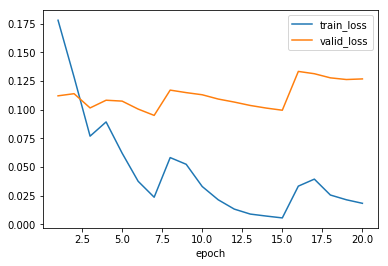

In [144]:
cb['history'].plot(['train_loss', 'valid_loss'])

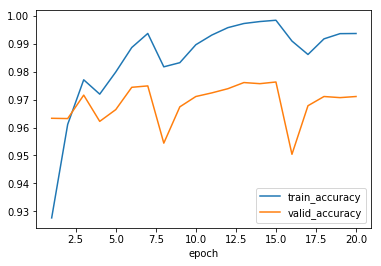

In [145]:
cb['history'].plot(['train_accuracy', 'valid_accuracy'])

In [39]:
def training_status(layer):
    params = list(layer.parameters())
    if not params:
        return 'no params'
    trainable = [p for p in params if p.requires_grad]
    return 'frozen' if not trainable else ''

In [40]:
def freeze_status(m, stream=sys.stdout):
    """Flattens the model and prints its require_grad value."""
    stream.write('Layers status\n')
    stream.write('-' * 80 + '\n')
    for layer in flat_model(m):
        name = layer.__class__.__name__
        status = training_status(layer)
        stream.write(f'{name:<68} [{status:9s}]\n')
    stream.flush()

In [ ]:
freeze_status(model)

In [ ]:
def traverse(root, visit):
    
    def recurse(m, depth, index):
        if depth >= 0:
            visit(m, depth, index)
        for index, child in enumerate(m.children()):
            if hasattr(child, '__getitem__'):
                recurse(child, depth+1, index)
            else:
                visit(child, depth+1, index)
        
    return recurse(root, -1, 0)

In [50]:
DATA = Path.home()/'data'/'quick_draw'
SMALL = DATA/'images'/'500'
LARGE = DATA/'images'/'50000'
TEST = DATA/'test'/'rgb'
CSV = DATA/'prepared'
RAW_SIZE = 256, 256
COLORS = ['#0095EF', '#3C50B1', '#6A38B3', '#A224AD', '#F31D64', '#FE433C']

In [51]:
from itertools import cycle

import PIL.Image
import PIL.ImageDraw

In [52]:
class ImageRenderer:
    """Converts string with strokes into PIL image."""

    def __init__(self, mode='b/w', bg='black', fg='white', lw: int=4,
                 colors=None):

        mode = mode if mode in ('b/w', 'rgb') else 'b/w'

        self.render_fn = {
            'b/w': render_bw,
            'rgb': render_rgb
        }[mode]

        self.mode = mode
        self.bg = bg
        self.fg = fg
        self.lw = lw
        self.colors = cycle(colors or COLORS)

    def render(self, strokes: str, image_size: tuple):
        x_ref, y_ref = RAW_SIZE
        x_max, y_max = image_size
        ratio = x_max/float(x_ref), y_max/float(y_ref)
        return self.render_fn(self, strokes, ratio, image_size)


def render_bw(renderer, strokes, ratio, image_size):
    bg, fg, lw = [getattr(renderer, x) for x in 'bg fg lw'.split()]

    x_ratio, y_ratio = ratio
    canvas = PIL.Image.new('RGB', image_size, color=bg)
    draw = PIL.ImageDraw.Draw(canvas)

    for segment in strokes.split('|'):
        chunks = [int(x) for x in segment.split(',')]
        while len(chunks) >= 4:
            (x1, y1, x2, y2), chunks = chunks[:4], chunks[2:]
            scaled = (
                int(x1 * x_ratio), int(y1 * y_ratio),
                int(x2 * x_ratio), int(y2 * y_ratio))
            draw.line(tuple(scaled), fill=fg, width=lw)

    return canvas


def render_rgb(renderer, strokes, ratio, image_size):
    colors, bg, lw = [getattr(renderer, x) for x in 'colors bg lw'.split()]

    x_ratio, y_ratio = ratio
    canvas = PIL.Image.new('RGB', image_size, color=bg)
    draw = PIL.ImageDraw.Draw(canvas)

    for segment, color in zip(strokes.split('|'), colors):
        chunks = [int(x) for x in segment.split(',')]
        while len(chunks) >= 4:
            (x1, y1, x2, y2), chunks = chunks[:4], chunks[2:]
            scaled = (
                int(x1 * x_ratio), int(y1 * y_ratio),
                int(x2 * x_ratio), int(y2 * y_ratio))
            draw.line(tuple(scaled), fill=color, width=lw)

    return canvas


default_renderer = ImageRenderer('rgb', bg='white')

In [53]:
from functools import partial
from pathlib import Path
from multiprocessing import Pool, cpu_count

from fastai.vision import ImageDataBunch, imagenet_stats
import numpy as np
import pandas as pd
import PIL.Image
from torch.nn.functional import cross_entropy
from torch.utils.data import Dataset
from torchvision.datasets.folder import pil_loader, is_image_file


class Doodles(Dataset):

    def __init__(self, root: Path, train: bool=True,
                 subset_size: int=None, image_size: int=RAW_SIZE,
                 renderer=default_renderer, transforms=None):

        subfolder = root/('train' if train else 'valid')
        if isinstance(image_size, int):
            image_size = image_size, image_size

        worker = partial(read_category, subset_size)
        with Pool(cpu_count()) as pool:
            data = pool.map(worker, subfolder.glob('*.csv'))

        merged = pd.concat(data)
        targets = merged.word.values
        classes = np.unique(targets)
        class2idx = {v: k for k, v in enumerate(classes)}
        labels = np.array([class2idx[c] for c in targets])

        self.root = root
        self.train = train
        self.subset_size = subset_size
        self.image_size = image_size
        self.renderer = renderer
        self.data = merged.drawing.values
        self.classes = classes
        self.class2idx = class2idx
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        strokes, target = self.data[item], self.labels[item]
        img = self.renderer.render(strokes, self.image_size)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, target


class TestImagesFolder(Dataset):

    def __init__(self, path, image_size=RAW_SIZE,
                 loader=pil_loader, pseudolabel=0):

        path = Path(path)

        if isinstance(image_size, int):
            image_size = image_size, image_size

        assert path.is_dir() and path.exists(), 'Not a directory!'
        assert path.stat().st_size > 0, 'Directory is empty'

        images = [file for file in path.iterdir() if is_image_file(str(file))]

        self.path = path
        self.image_size = image_size
        self.loader = loader
        self.images = images
        self.pseudolabel = pseudolabel

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        img = self.loader(self.images[item])
        img.thumbnail(self.image_size, PIL.Image.ANTIALIAS)
        return img, self.pseudolabel
    
    
def read_category(subset_size, path):
    if subset_size is None:
        return pd.read_csv(path)

    data = pd.DataFrame()
    for chunk in pd.read_csv(path, chunksize=min(10000, subset_size)):
        data = data.append(chunk)
        if len(data) >= subset_size:
            break

    return data[:subset_size]

In [54]:
from torchvision.transforms import *
from torchvision.datasets.folder import ImageFolder

In [60]:
n = 12
n_jobs = default(n, cpu_count())
epochs = 1
batch_size = 1600
image_size = 128
device = torch.device('cuda:1')

train_tfms = Compose([
    RandomCrop(image_size),
    RandomAffine(degrees=5,
                 translate=(0.05, 0.05),
                 scale=(0.9, 1.1)),
    # RandomHorizontalFlip(),  
    ToTensor(),
    Normalize(*imagenet_stats)
])

valid_tfms = Compose([
    RandomCrop(image_size),
    ToTensor(),
    Normalize(*imagenet_stats)
])


train_ds = Doodles(CSV, train=True, subset_size=50000, image_size=image_size, transforms=train_tfms)
valid_ds = Doodles(CSV, train=False, subset_size=50, image_size=image_size, transforms=valid_tfms)

phases = [
    Phase('train', DataLoader(train_ds, batch_size, shuffle=True, num_workers=n_jobs)),
    Phase('valid', DataLoader(valid_ds, batch_size, num_workers=n_jobs), grad=False)
]

# model = Net().to(device)
# opt = optim.Adam(model.parameters(), lr=1e-2)

model = Classifier(340, arch=models.resnet18).to(device)
model.freeze_backbone()
opt = optim.Adam(model.parameters(), lr=1e-2)

# opt = optim.Adam([
#     {'params': model.backbone.parameters(), 'lr': 1e-3},
#     {'params': model.top.parameters(), 'lr': 1e-2}
# ])

loss_fn = nn.CrossEntropyLoss()
cb = CallbacksGroup([History(), 
                     Scheduler(
                         CosineAnnealingSchedule(
                             eta_min=0.01, 
                             t_max=len(phases[0].loader)), 
                         mode='batch'),
                     RollingLoss(), 
                     Accuracy(),
                     StreamLogger(), 
                     ProgressBar()])
cb.training_started(phases=phases, optimizer=opt)

for epoch in range(1, epochs + 1):
    cb.epoch_started(epoch=epoch)

    for phase in phases:
        n = len(phase.loader)
        cb.phase_started(phase=phase, total_batches=n)
        is_training = phase.grad
        model.train(is_training)
        
        for batch in phase.loader:
#             breakpoint()
            phase.batch_index += 1
            cb.batch_started(phase=phase, total_batches=n)
            x, y = place_and_unwrap(batch, device)
            
            with torch.set_grad_enabled(is_training):
                cb.before_forward_pass()
                out = model(x)
                cb.after_forward_pass()
                loss = loss_fn(out, y)
            
            if is_training:
                opt.zero_grad()
                cb.before_backward_pass()
                loss.backward()
                cb.after_backward_pass()
                opt.step()
            
            phase.batch_loss = loss.item()
            cb.batch_ended(phase=phase, output=out, target=y)
            
        cb.phase_ended(phase=phase)
    
    cb.epoch_ended(phases=phases, epoch=epoch)
    
cb.training_ended(phases=phases)

Epoch:    1 | train_loss=2.5402, train_accuracy=0.3428, valid_loss=2.0384, valid_accuracy=0.4827


In [58]:
MNIST('~/data/mnist', train=True, transform=Compose([ToTensor()]))[0][1]

5

In [61]:
len(valid_ds)

17000